In [41]:
# refer: https://github.com/Currie32/Predicting-the-Dow-Jones-with-Headlines/blob/master/Predict_Dow_with_News.ipynb
import os
import sys
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
#import tqdm
import re
from nltk.corpus import stopwords

%matplotlib inline


In [2]:
news = pd.read_csv("News.csv")
dj = pd.read_csv('DowJones.csv')

In [3]:
news = news[news.Date.isin(dj.Date)]

In [4]:
dj = dj.set_index('Date').diff(periods=1)

In [5]:
dj['Date'] = dj.index

In [6]:
dj = dj.reset_index(drop=True)

In [7]:
dj = dj.drop(['High', 'Low', 'Close', 'Volume', 'Adj Close'], 1)

In [8]:
dj = dj[dj.Open.notnull()]

In [9]:
price = []
headlines = []
for i, dj_row  in dj.iterrows():
    dj_date = dj_row['Date']
    price.append(dj_row['Open'])
    news_selected_date = news[news.Date==dj_date]
    
    temp=''
    for str_headline in news_selected_date['News'].values:
        temp+=str_headline  

    headlines.append(temp)

In [10]:
 news_selected_date['News'].values

array(['b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"',
       "b'BREAKING: Musharraf to be impeached.'",
       "b'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)'",
       "b'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire'",
       'b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing"',
       "b'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.'",
       'b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side"',
       'b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it."',
       "b'Georgian troops retreat from S. Osettain capital, presumably leaving several hundre

In [11]:
headlines_df = pd.DataFrame(data=headlines, index=dj.Date,columns=['headlines'])

In [12]:
headlines_df

,headlines
Date,
2016-06-30,Jamaica proposes marijuana dispensers for tour...
2016-06-29,Explosion At Airport In IstanbulYemeni former ...
2016-06-28,"2,500 Scientists To Australia: If You Want To ..."
2016-06-27,Barclays and RBS shares suspended from trading...
2016-06-24,David Cameron to Resign as PM After EU Referen...
2016-06-23,Today The United Kingdom decides whether to re...
2016-06-22,German government agrees to ban fracking indef...
2016-06-21,An Australian athlete who has competed in six ...
2016-06-20,A staggering 87 percent of Venezuelans say the...


In [13]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [14]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    text = re.sub(r'b ', ' ', text)
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [15]:
headlines_df['cleaned_headlines']=headlines_df['headlines'].map(clean_text)

In [16]:
all_words = set()
for headline in headlines_df['cleaned_headlines'].values:
    all_words.update(headline.split(" "))

In [17]:
len(all_words)

54895

In [18]:
headlines_df

,headlines,cleaned_headlines
Date,,
2016-06-30,Jamaica proposes marijuana dispensers for tour...,jamaica proposes marijuana dispensers tourists...
2016-06-29,Explosion At Airport In IstanbulYemeni former ...,explosion airport istanbulyemeni former presid...
2016-06-28,"2,500 Scientists To Australia: If You Want To ...",2 500 scientists australia want save great bar...
2016-06-27,Barclays and RBS shares suspended from trading...,barclays rbs shares suspended trading tanking ...
2016-06-24,David Cameron to Resign as PM After EU Referen...,david cameron resign pm eu referendumbbc forec...
2016-06-23,Today The United Kingdom decides whether to re...,today united kingdom decides whether remain eu...
2016-06-22,German government agrees to ban fracking indef...,german government agrees ban fracking indefini...
2016-06-21,An Australian athlete who has competed in six ...,australian athlete competed six paralympic gam...
2016-06-20,A staggering 87 percent of Venezuelans say the...,staggering 87 percent venezuelans say money bu...


In [55]:
headlines_df['cleaned_headlines_shuffle'] = np.random.permutation(headlines_df['cleaned_headlines'].values)

In [56]:
headlines_df.head()

,headlines,cleaned_headlines,cleaned_headlines_shuffle
Date,,,
2016-06-30,Jamaica proposes marijuana dispensers for tour...,jamaica proposes marijuana dispensers tourists...,lifetime ban blood donations homosexual bisexu...
2016-06-29,Explosion At Airport In IstanbulYemeni former ...,explosion airport istanbulyemeni former presid...,france passes gay marriage bill legislation le...
2016-06-28,"2,500 Scientists To Australia: If You Want To ...",2 500 scientists australia want save great bar...,new airport scanners break child porn laws ind...
2016-06-27,Barclays and RBS shares suspended from trading...,barclays rbs shares suspended trading tanking ...,unbelievable hypocrisy islamic hate preacher s...
2016-06-24,David Cameron to Resign as PM After EU Referen...,david cameron resign pm eu referendumbbc forec...,wikileaks reveals nsa spies almost afghanistan...


In [19]:

GLOVE_DIR  = '../glove.6B/'
MAX_SEQUENCE_LENGTH = 150
MAX_NUM_WORDS = 55000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

In [20]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [57]:
texts = list(headlines_df['cleaned_headlines_shuffle'].values)


In [58]:
len(texts), len(price)

(1988, 1988)

In [59]:
# finally, vectorize the text samples into a 2D integer tensor
#MAX_NUM_WORDS=180000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 54389 unique tokens.


In [60]:
print(max(len(s) for s in sequences))
print(min(len(s) for s in sequences))

465
170


In [61]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [62]:
data.shape

(1988, 150)

In [63]:
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    

In [64]:
embedding_matrix.shape

(54390, 300)

In [65]:
from keras.layers import Embedding


In [66]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix.


In [67]:
embedding_matrix.shape, MAX_SEQUENCE_LENGTH

((54390, 300), 150)

In [68]:
print('Training model.')

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras import optimizers
from keras.optimizers import Adam, SGD, RMSprop


model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM , input_length=MAX_SEQUENCE_LENGTH, weights= [embedding_matrix], trainable=False))

#model.add(Dropout(0.2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.5))
#model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001,clipvalue=1.0), metrics=['mse', 'accuracy'])



Training model.


In [69]:
'''
print('Training model by two inputs.')
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras import optimizers
from keras.optimizers import Adam, SGD, RMSprop

from keras.layers.merge import concatenate
from keras.layers import Embedding, Input


# First LSTM
input_1 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_1 = Embedding(num_words, EMBEDDING_DIM , input_length=MAX_SEQUENCE_LENGTH, weights= [embedding_matrix], trainable=False)(input_1)
conv_1 = Conv1D(64, 3, activation='relu')(embedding_1)
max_p1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(64, 5, activation='relu')(max_p1)
max_p2 = MaxPooling1D(pool_size=2)(conv_2)
LSTM_1 = LSTM(512, dropout=0.1, recurrent_dropout=0.5)(max_p2)

# Second LSTM
# First LSTM
input_2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_2 = Embedding(num_words, EMBEDDING_DIM , input_length=MAX_SEQUENCE_LENGTH, weights= [embedding_matrix], trainable=False)(input_2)
conv_3 = Conv1D(64, 7, activation='relu')(embedding_2)
max_p3 = MaxPooling1D(pool_size=2)(conv_3)
conv_4 = Conv1D(64, 9, activation='relu')(max_p3)
max_p4 = MaxPooling1D(pool_size=2)(conv_4)
LSTM_2 = LSTM(512, dropout=0.1, recurrent_dropout=0.5)(max_p4)




# Merge
merged = concatenate([LSTM_1, LSTM_2])

# Dense
dense_out_1 = Dense(128)(merged)
dense_out_final = Dense(1)(dense_out_1)

# build and compile model
model = Model(inputs=[input_1, input_2], outputs=[dense_out_final])

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001,clipvalue=1.0), metrics=['mse', 'accuracy'])
'''

"\nprint('Training model by two inputs.')\nfrom keras import layers\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation\nfrom keras import optimizers\nfrom keras.optimizers import Adam, SGD, RMSprop\n\nfrom keras.layers.merge import concatenate\nfrom keras.layers import Embedding, Input\n\n\n# First LSTM\ninput_1 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')\nembedding_1 = Embedding(num_words, EMBEDDING_DIM , input_length=MAX_SEQUENCE_LENGTH, weights= [embedding_matrix], trainable=False)(input_1)\nconv_1 = Conv1D(64, 3, activation='relu')(embedding_1)\nmax_p1 = MaxPooling1D(pool_size=2)(conv_1)\nconv_2 = Conv1D(64, 5, activation='relu')(max_p1)\nmax_p2 = MaxPooling1D(pool_size=2)(conv_2)\nLSTM_1 = LSTM(512, dropout=0.1, recurrent_dropout=0.5)(max_p2)\n\n# Second LSTM\n# First LSTM\ninput_2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')\nembedding_2 = Embedding(num_words, EMBEDDING_DIM , input_length

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 300)          16317000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 148, 64)           57664     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 74, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 70, 64)            20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 35, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1181696   
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
__________

In [71]:
# Normalize opening prices (target values)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [72]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, norm_price, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [73]:

history = model.fit([x_train], y_train, batch_size=32, epochs=20, validation_split=0.2)

Train on 1351 samples, validate on 338 samples
Epoch 1/20
1351/1351 [==============================] - 7s 5ms/step - loss: 0.2085 - mean_squared_error: 0.2085 - acc: 7.4019e-04 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_acc: 0.0000e+00
Epoch 2/20
1351/1351 [==============================] - 6s 5ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - acc: 0.0015 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_acc: 0.0000e+00
Epoch 3/20
1351/1351 [==============================] - 6s 4ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - acc: 0.0015 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_acc: 0.0000e+00
Epoch 4/20
1351/1351 [==============================] - 6s 4ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - acc: 0.0015 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_acc: 0.0000e+00
Epoch 5/20
1351/1351 [==============================] - 6s 4ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - acc: 0.0015 - val_loss: 0.0086 - va

dict_keys(['val_loss', 'val_mean_squared_error', 'val_acc', 'loss', 'mean_squared_error', 'acc'])


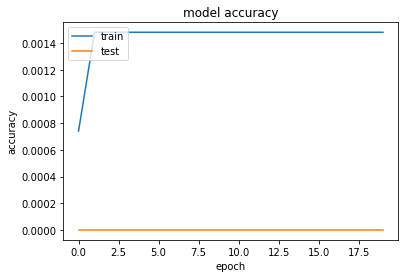

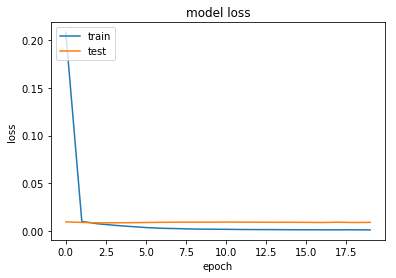

In [85]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:
predictions = model.predict([x_test], verbose = True)

299/299 [==============================] - 0s 1ms/step


In [87]:
from sklearn.metrics import mean_squared_error as mse

mse(y_test, predictions)

0.008752451287801017

In [88]:
def unnormalize(price):
    '''Revert values to their unnormalized amounts'''
    price = price*(max_price-min_price)+min_price
    return(price)

In [89]:
unnorm_predictions = []
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))
    
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [90]:
from sklearn.metrics import median_absolute_error as mae

mae(unnorm_y_test, unnorm_predictions)

82.30560240234263

In [91]:
print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

Summary of actual opening price changes
                 
count  299.000000
mean    -7.094101
std    139.532324
min   -541.050782
25%    -87.465332
50%    -10.759766
75%     54.689941
max    673.139648

Summary of predicted opening price changes
                 
count  299.000000
mean   -13.207725
std     62.756838
min   -197.240112
25%    -56.524414
50%    -21.897766
75%     32.370697
max    200.350708


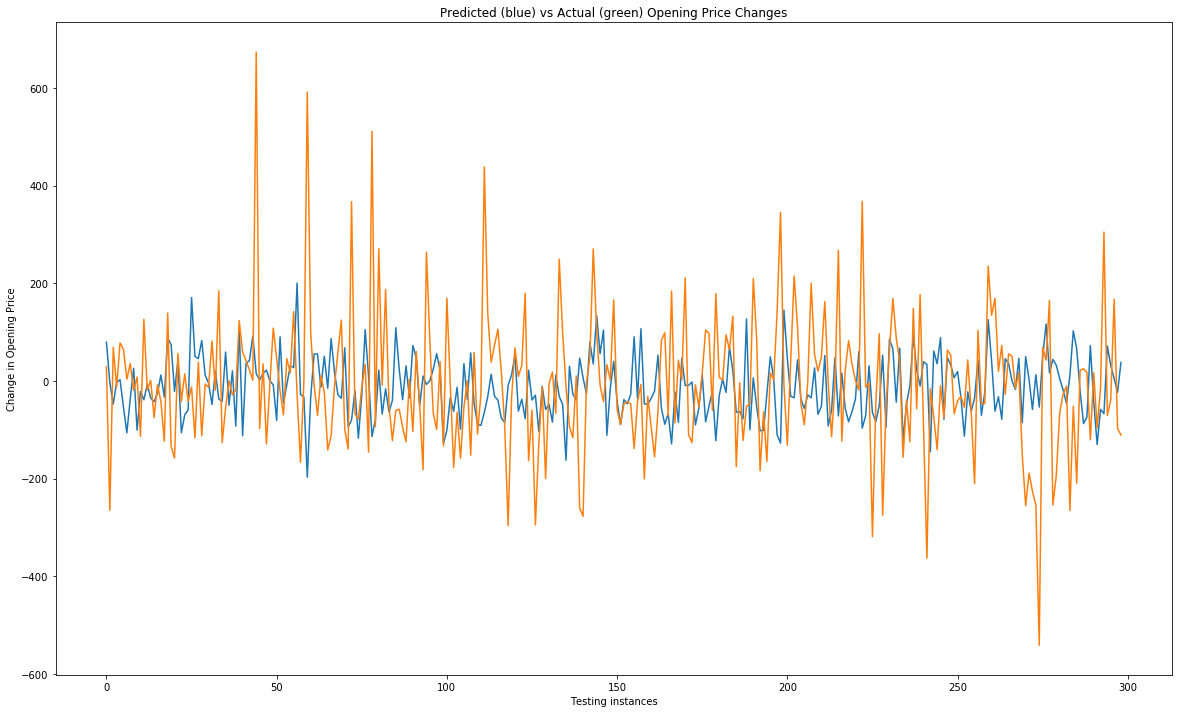

In [92]:
# Plot the predicted (blue) and actual (green) values
plt.figure(figsize=(20,12))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted (blue) vs Actual (green) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [93]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [94]:
from sklearn.metrics import accuracy_score as acc

# Calculate if the predicted direction matched the actual direction
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))

Predicted values matched the actual direction 49.830000000000005% of the time.
